In [1]:
import os
import sys 
import csv
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from visual_genome.local import VisualGenome


C:\Users\karab\AppData\Local\Temp\ipykernel_14908\974091014.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\karab\Desktop\Visual Genome Driver\env\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
vg = VisualGenome()

Script directory: C:\Users\karab\Desktop\Visual Genome Driver\visual_genome
Data directory: C:\Users\karab\Desktop\Visual Genome Driver\data
Loading data...
Data loaded.


In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
models = [
    'all-mpnet-base-v2',  # approx 8 min to load the model
    'gte-large-en-v1.5',  # approx 17 min to load the model
]
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')  # takes approx 5 min to load

# model = SentenceTransformer("all-mpnet-base-v2", trust_remote_code=True).cuda()
model_name = 'all-mpnet-base-v2'

c:\Users\karab\Desktop\Visual Genome Driver\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
def get_embeddings(model, region_sentences):
    sentence_embeddings = model.encode(region_sentences)
    return sentence_embeddings

In [6]:
def preprocess_text(text):
    # Define a mapping of special characters to their English counterparts
    replacements = {
        'á': 'a',
        'é': 'e',
        'ç': 'c',
        'ÿ': 'y',
        'ñ': 'n'
    }
    
    # Create translation table
    translation_table = str.maketrans(replacements)
    
    # Replace special characters, remove commas, underscores, and convert to lowercase
    text = text.translate(translation_table)   # Replace special characters
    text = text.replace(",", "").replace("_", " ")  # Remove commas and replace underscores with spaces
    text = text.lower()  # Convert to lowercase
    
    return text

In [7]:
def process_entity(entity):
    
    entity_list = {}
    aux = {}
    images = vg.get_images()
    
    for id in vg.get_image_ids():
        if entity == "regions":
            image_regions = images[id]["regions"]
            region_sentences = []
            for region in image_regions:
                region_sentences.append(preprocess_text(region.phrase))
            
            entity_list[id] = region_sentences
        elif entity == "objects":
            image_objects = vg.get_image_objects(id)
            object_names = []
            object_sizes = []
            for obj in image_objects:
                object_names.append(preprocess_text(obj.name))
                object_sizes.append(obj.width * obj.height)
            entity_list[id] = object_names
            aux[id] = object_sizes
        elif entity == "relationships":
            rels = vg.get_image_relationships(id)
            rel_sentences = []
            for rel in rels:
                object = preprocess_text(rel.object_name)
                subject = preprocess_text(rel.subject_name)
                predicate = preprocess_text(rel.predicate)
                
                rel_sentences.append(f"{subject} {predicate} {object}")
            entity_list[id] = (rel_sentences)
        else: 
            print("Invalid entity")
            return None
    
    return entity_list, aux
            

In [8]:
def get_embeddings_from_entity(img_to_entity, model, dim):
    img_to_entity_embeddings = {}
    for im in tqdm(img_to_entity.keys()):
        entity_list = img_to_entity[im]
        if entity_list:
            embeddings = get_embeddings(model, entity_list)
        else:
            embeddings = torch.zeros(dim)  # embedding dimensions of the model
        img_to_entity_embeddings[im] = embeddings
    return img_to_entity_embeddings

In [9]:
def calculate_similarities(img_to_entity_embeddings, model, aux = None):
    img_to_avg_similarities = {}
    img_to_similarity_vec = {}
    for im in tqdm(img_to_entity_embeddings.keys()):
        
        sim = model.similarity(img_to_entity_embeddings[im], img_to_entity_embeddings[im])
        if aux:
            weights = np.array(aux[im])
            square = np.sqrt(weights)
            
            wij = np.outer(square, square)
            sim = sim * wij
            
            wij_vectorized = np.triu(wij, k=1)
            sim_vectorized = np.triu(sim, k=1)
            
            mean = wij_vectorized.sum() / sim_vectorized.sum() 
            img_to_avg_similarities[im] = mean
        else:
            vec = sim[np.triu_indices(len(sim), k=1)]
            img_to_avg_similarities[im] = vec.mean()
            img_to_similarity_vec[im] = vec
            
    return img_to_avg_similarities, img_to_similarity_vec

In [10]:
def plot(img_to_avg_similarities, text):
    plt.hist(list(img_to_avg_similarities.values()), bins=100)
    plt.title(f"text")
    plt.xlabel("Average Similarity")
    plt.ylabel("Frequency")
    plt.show()

In [11]:
def sample_images(img_to_avg_region_similarities, lo, hi):
    similar_images = [k for k, v in img_to_avg_region_similarities.items() if v >= hi]
    dissimilar_images = [k for k, v in img_to_avg_region_similarities.items() if v <= lo]
    
    similar_ims = list(np.random.choice(similar_images, 9))
    dissimilar_ims = list(np.random.choice(dissimilar_images, 9))

    print("Similar images")
    vg.visualize_images_side_by_side(similar_ims)
    print("Dissimilar images")
    vg.visualize_images_side_by_side(dissimilar_ims)
    
    return similar_ims, dissimilar_ims

In [12]:
def save_to_csv(img_to_avg_similarities, filename):
    # write img_to_avg similarities to csv
    with open(filename, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["image_id", "avg_similarity"])
        for key, value in img_to_avg_similarities.items():
            writer.writerow([key, value])
    

def write_to_features(img_to_avg_similarities, field):
    features = pd.read_csv("features.csv")
    features[field] = features["image_id"].apply(lambda x: img_to_avg_similarities[x])
    features.to_csv("features.csv", index=False)
    

In [37]:
def get_spearman_corr(img_to_avg_similarities_1, img_to_avg_similarities_2):
    list1 = []
    list2 = []
    for x in img_to_avg_similarities_1.keys():
        val1 = img_to_avg_similarities_1[x].item()
        val2 = img_to_avg_similarities_2[x].item()
        if str(val1) != 'nan' and str(val2) != 'nan':
            list1.append(val1)
            list2.append(val2)
            
    print(spearmanr(list1, list2))

In [14]:
img_to_regions, _ = process_entity("regions")
img_to_region_embeddings = get_embeddings_from_entity(img_to_regions, model, 768)
img_to_avg_region_similarities, img_to_region_similarity_vec = calculate_similarities(img_to_region_embeddings, model)

100%|██████████| 108077/108077 [04:52<00:00, 369.90it/s] 


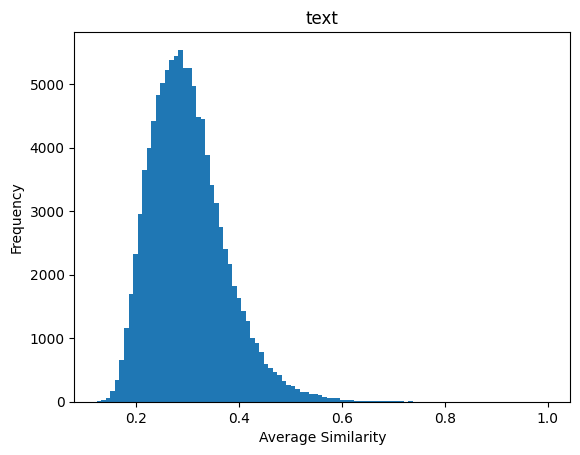

In [197]:
plot(img_to_avg_region_similarities, "Average Similarity in Images based on Region Descriptions")

[2386869, 2330192, 2330749, 2382723, 2373035, 3128, 2338311, 2374414, 738]
[2360840, 2360939, 2389316, 2336405, 1593155, 2320861, 2362239, 2384578, 2317278]


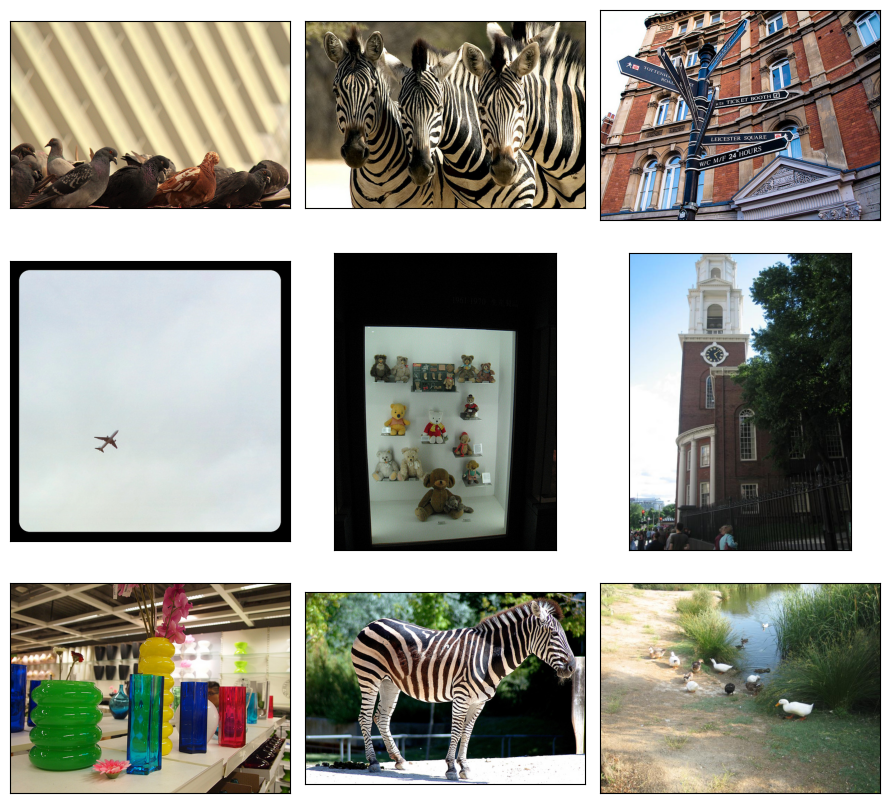

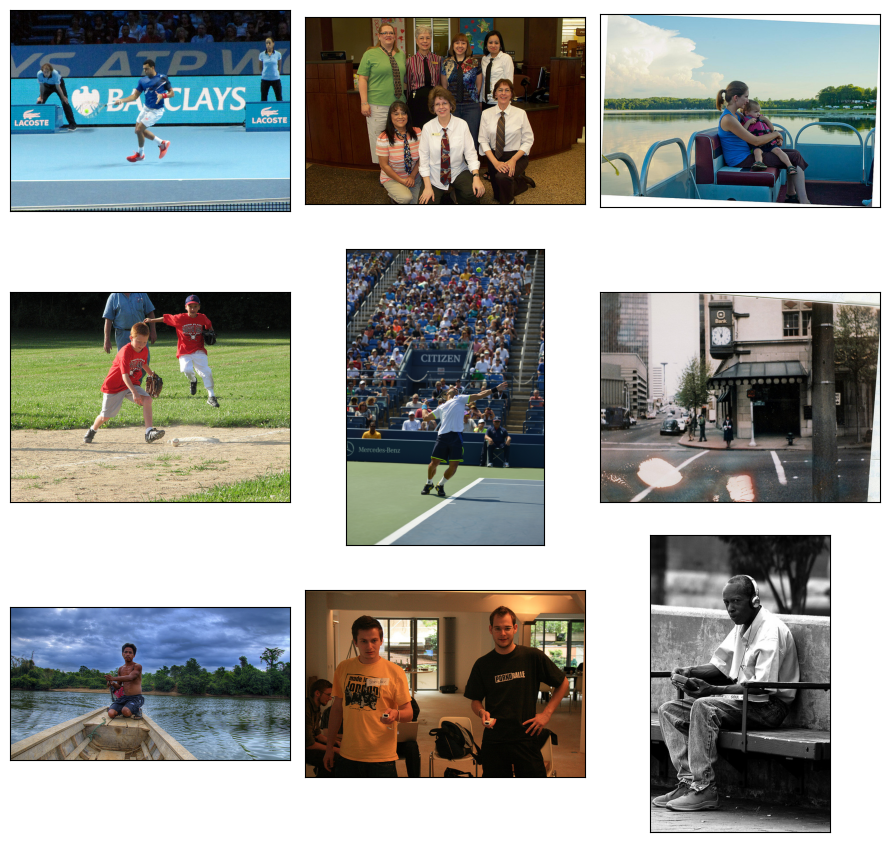

([id: 2386869, coco_id: 181034, flickr_id: 9480115279, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K_2/2386869.jpg,
  id: 2330192, coco_id: -1, flickr_id: 2692923748, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K/2330192.jpg,
  id: 2330749, coco_id: -1, flickr_id: 2152065952, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K/2330749.jpg,
  id: 2382723, coco_id: 455943, flickr_id: 5343003555, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K_2/2382723.jpg,
  id: 2373035, coco_id: -1, flickr_id: 4741619488, width: 375, url: https://cs.stanford.edu/people/rak248/VG_100K/2373035.jpg,
  id: 3128, coco_id: -1, flickr_id: -1, width: 600, url: https://cs.stanford.edu/people/rak248/VG_100K_2/3128.jpg,
  id: 2338311, coco_id: -1, flickr_id: 6228978551, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K/2338311.jpg,
  id: 2374414, coco_id: 137734, flickr_id: 677921002, width: 500, url: https://cs.stanford.edu/people/rak248/VG

In [208]:
sample_images(img_to_avg_region_similarities, 0.25, 0.5)

## Objects

In [15]:
img_to_objects, img_to_object_sizes = process_entity("objects")
img_to_object_embeddings = get_embeddings_from_entity(img_to_objects, model, 768)
img_to_avg_object_similarities, img_to_object_similarity_vec = calculate_similarities(img_to_object_embeddings, model)

100%|██████████| 108077/108077 [01:03<00:00, 1691.08it/s]


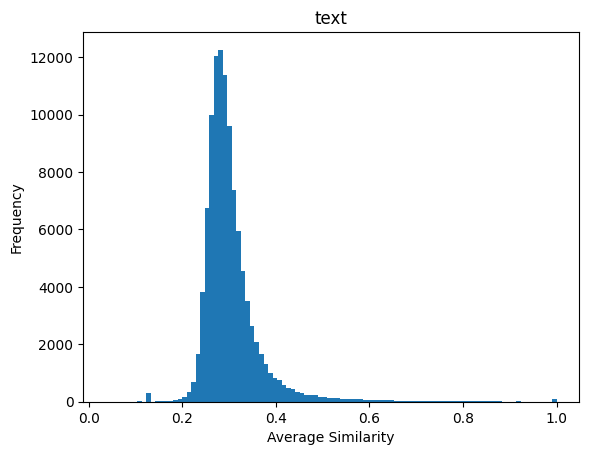

In [16]:
plot(img_to_avg_object_similarities, "Average Similarity in Images based on Objects")

Similar images


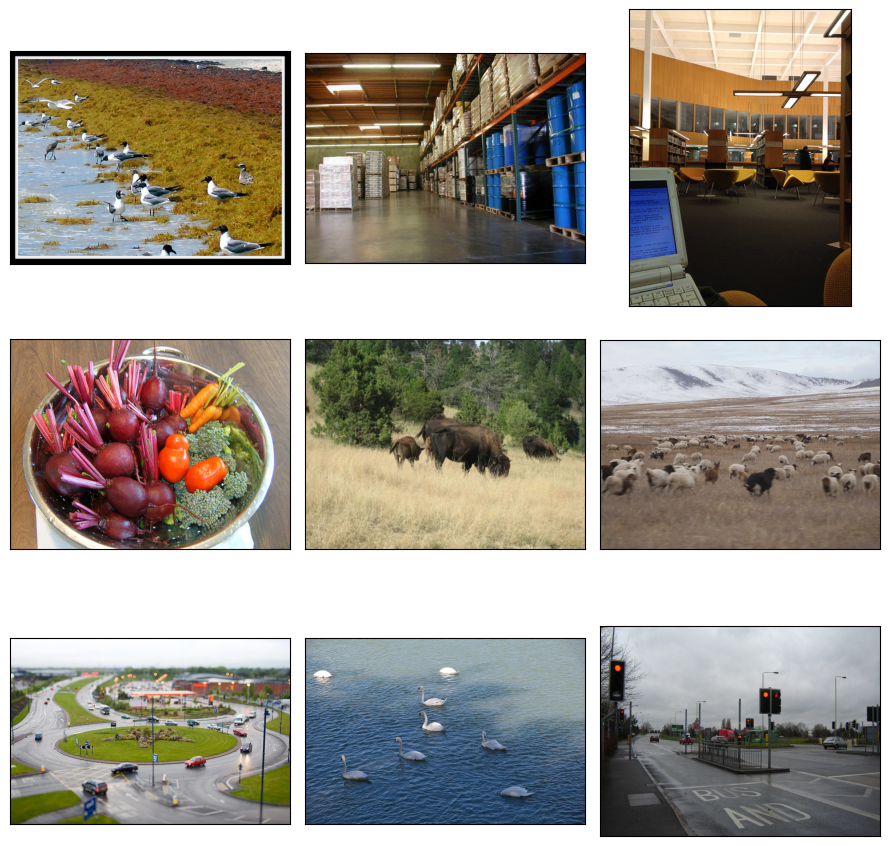

Dissimilar images


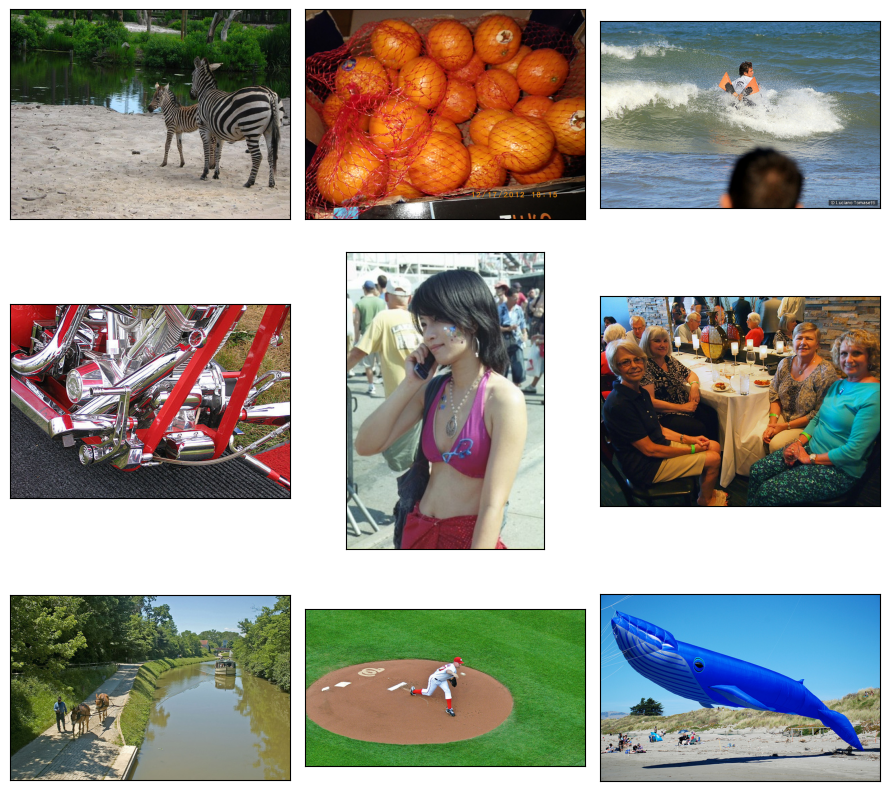

([id: 2337384, coco_id: -1, flickr_id: 2701259397, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K/2337384.jpg,
  id: 4555, coco_id: -1, flickr_id: -1, width: 800, url: https://cs.stanford.edu/people/rak248/VG_100K_2/4555.jpg,
  id: 2413977, coco_id: 493692, flickr_id: 6802648517, width: 375, url: https://cs.stanford.edu/people/rak248/VG_100K_2/2413977.jpg,
  id: 2349441, coco_id: -1, flickr_id: 2748223880, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K/2349441.jpg,
  id: 2521, coco_id: -1, flickr_id: -1, width: 800, url: https://cs.stanford.edu/people/rak248/VG_100K_2/2521.jpg,
  id: 2417655, coco_id: -1, flickr_id: 6622947341, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K_2/2417655.jpg,
  id: 2417446, coco_id: -1, flickr_id: 3534851444, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K_2/2417446.jpg,
  id: 2364671, coco_id: 481628, flickr_id: 9413369426, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K/2364671

In [17]:
sample_images(img_to_avg_object_similarities, 0.25, 0.5)

## <Subject, Predicate, Object> Triples

In [18]:
img_to_relationships, _ = process_entity("relationships")
img_to_relationship_embeddings = get_embeddings_from_entity(img_to_relationships, model, 768)
img_to_avg_rel_similarities, img_to_region_rel_vec = calculate_similarities(img_to_relationship_embeddings, model)

100%|██████████| 108077/108077 [00:22<00:00, 4804.46it/s]


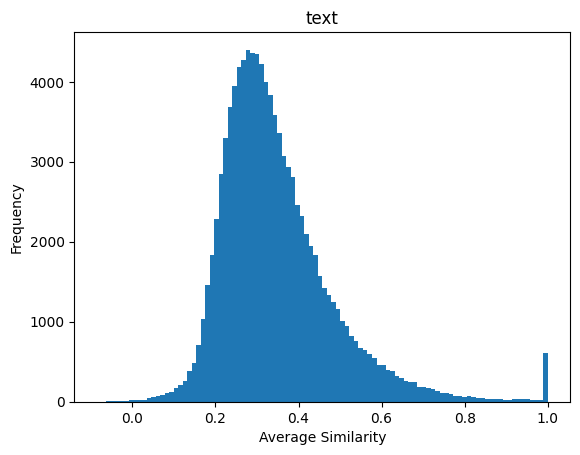

In [19]:
plot(img_to_avg_rel_similarities, "Average Similarity in Images based on Relationships (Subject Predicate Object)")

Similar images


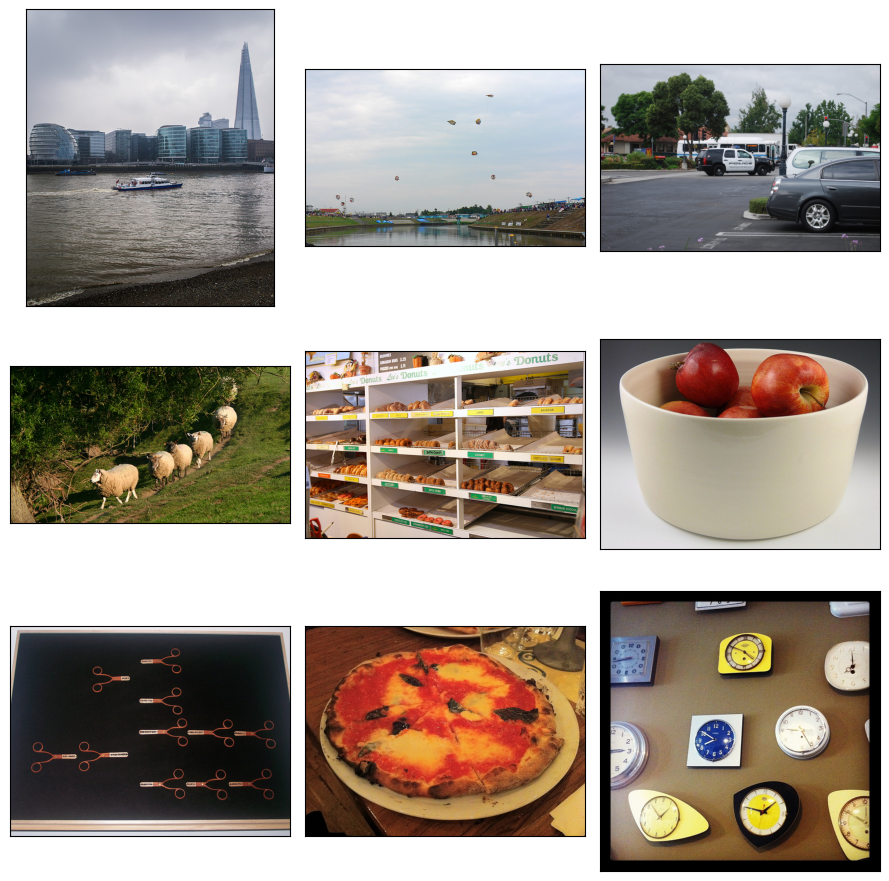

Dissimilar images


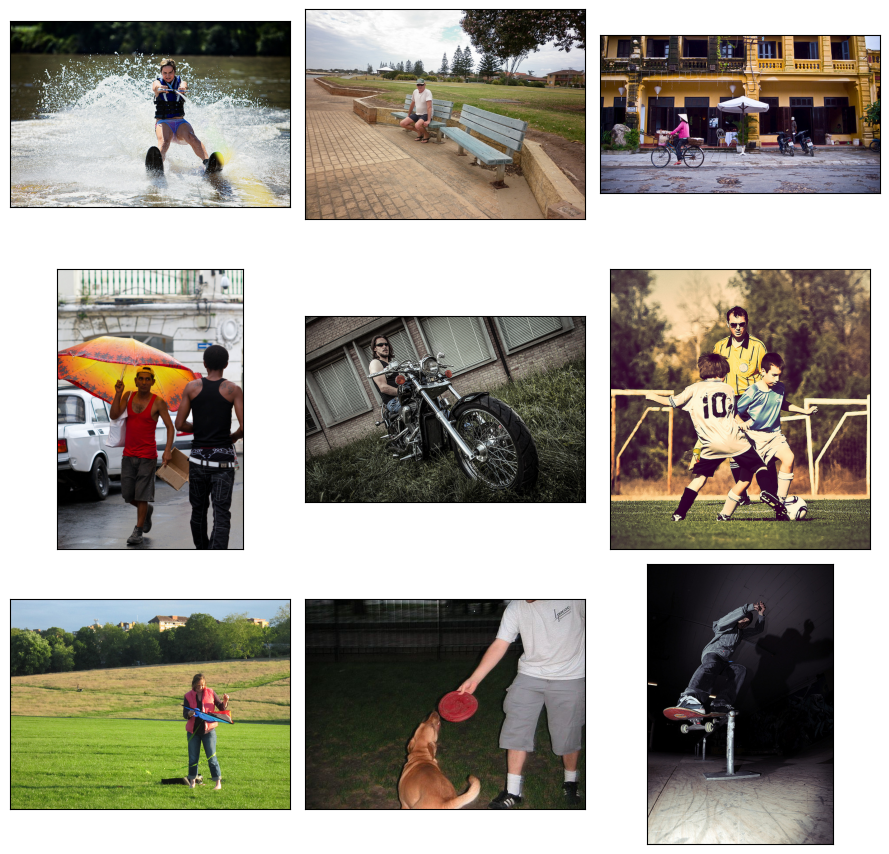

([id: 2348523, coco_id: -1, flickr_id: 8608425317, width: 419, url: https://cs.stanford.edu/people/rak248/VG_100K/2348523.jpg,
  id: 2319018, coco_id: 245440, flickr_id: 560175725, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K/2319018.jpg,
  id: 1160120, coco_id: -1, flickr_id: 7315235362, width: 1024, url: https://cs.stanford.edu/people/rak248/VG_100K/1160120.jpg,
  id: 2323981, coco_id: 497194, flickr_id: 5847923654, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K/2323981.jpg,
  id: 2339169, coco_id: -1, flickr_id: 4130468309, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K/2339169.jpg,
  id: 2380700, coco_id: 360020, flickr_id: 6243586441, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K_2/2380700.jpg,
  id: 2357426, coco_id: -1, flickr_id: 2474879534, width: 500, url: https://cs.stanford.edu/people/rak248/VG_100K/2357426.jpg,
  id: 2339203, coco_id: 499313, flickr_id: 6158664257, width: 500, url: https://cs.stanford.edu/p

In [20]:
sample_images(img_to_avg_region_similarities, 0.25, 0.5)

In [45]:
print("Correlation between average similarities for region and objects:")
get_spearman_corr(img_to_avg_region_similarities, img_to_avg_object_similarities)  # 0.41
print("<-------------------------------------->")
print("Correlation between average similarities for region and relationships (subject, predicate, object):")
get_spearman_corr(img_to_avg_region_similarities, img_to_avg_rel_similarities)     # 0.58
print("<-------------------------------------->")
print("Correlation between average similarities for objects and relationships (subject, predicate, object)::")
get_spearman_corr(img_to_avg_object_similarities, img_to_avg_rel_similarities)     # 0.48
print("<-------------------------------------->")

Correlation between average similarities for region and objects:
SignificanceResult(statistic=0.4133776515109163, pvalue=0.0)
<-------------------------------------->
Correlation between average similarities for region and relationships (subject, predicate, object):
SignificanceResult(statistic=0.5859737110227691, pvalue=0.0)
<-------------------------------------->
Correlation between average similarities for objects and relationships (subject, predicate, object)::
SignificanceResult(statistic=0.48222756634699476, pvalue=0.0)
<-------------------------------------->
